In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm
import os
import seaborn as sns
import random
import math
sns.set(style="whitegrid")

Load and check data:

In [3]:
alldata = pd.read_csv("error_data.csv")

In [ ]:
alldata.head()

,participant,phase,condition,cue,target,response,rt,correct,Column1,Column2
0,1001.0,learn,1.0,EMPIRE,STATE,KING,3457.0,2.0,NaN,NaN
1,1001.0,learn,1.0,CHUNK,BLOCK,HUNK,3361.0,2.0,NaN,NaN
2,1001.0,learn,1.0,GLIDE,HANG,FLY,2177.0,2.0,NaN,NaN
3,1001.0,learn,1.0,SAIL,OCEAN,BOAT,2341.0,2.0,NaN,NaN
4,1001.0,learn,1.0,ELEVATOR,BUILDING,UP,3464.0,2.0,NaN,NaN


In [4]:
alldata.shape

(5670, 10)

Log likelihood

Implement ACT-R code:

In [5]:
def activation(traces, time, decay):
    """Computes the activation of a memory given its history of retrievals"""
    ftraces = [x for x in traces if x < time]
    decay = max(0, decay)  # Allows no positive decay rates in equation 
    decay - min(decay, 5)
    times = time - np.array(ftraces)
    odds = times ** -decay
    return np.log(np.sum(odds))

activation([5, 10, 15], 40, 0.5)

-0.5949230018850301

In [6]:
def responseTime(activation, k, Ter):
  retrieval = k / math.exp(activation)
  return retrieval + Ter

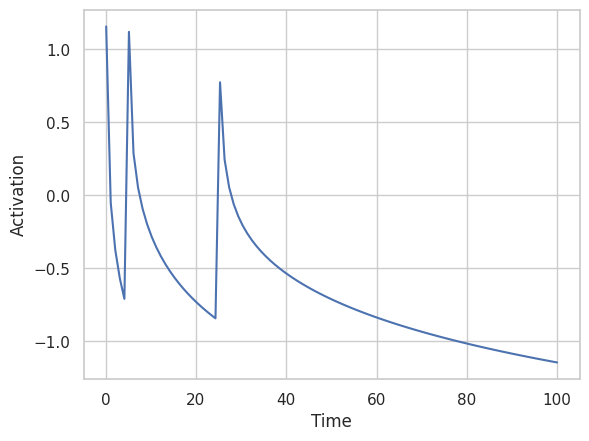

In [7]:
time = np.linspace(0.1, 100, 100)
traces = [0.001, 5, 25]
y = []
for t in time:
    act = activation(traces, t, 0.5)
    y += [act]
    
plt.plot(time, y)
plt.xlabel("Time")
plt.ylabel("Activation")
plt.show()

Create loglikelihood function for the model

In [8]:
def boltzmann(options, values, temperature):
    """Returns a Boltzmann distribution of the probabilities of each option"""
    temperature = max(temperature, 0.01) 
    vals = np.array(values)/temperature
    #bvals = np.exp(vals)/np.sum(np.exp(vals))
    bvals = np.exp(vals - np.max(vals)) / np.exp(vals - np.max(vals)).sum()
    return dict(zip(options, bvals))

In [9]:
boltzmann([2,3], [1, 0.7], 1)

{2: 0.574442516811659, 3: 0.425557483188341}

In [11]:
# test DF
testData = alldata[alldata.participant == 1001]
testData.shape

(90, 10)

In [10]:
testData.head()

NameError: ignored

In [12]:
"""For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
errors = testData[testData.phase == "learn"].cue.tolist()
    # create a list of study items
study = testData[testData.condition == 2].cue.tolist()
pos = 1
present = errors[:]

for i in range(len(errors)):
  word = study[i]
  present.insert(pos, word)
  pos += 2

print(present)

['EMPIRE', 'TASTY', 'CHUNK', 'BATTERY', 'GLIDE', 'NITROGEN', 'SAIL', 'MODEL', 'ELEVATOR', 'BLOCKADE', 'SWING', 'COOKOUT', 'DANCER', 'THEOREM', 'WELL', 'VISIT', 'EYES', 'ANCESTOR', 'INTRODUCE', 'SALES', 'PRESCRIPTION', 'CRITIC', 'CANYON', 'STAR', 'FUGITIVE', 'SINK', 'ORDER', 'USURP', 'LATIN', 'HOTEL', 'ROBIN', 'BISCUIT', 'PARCEL', 'LIE', 'LAUNDRY', 'EVICT', 'COURAGEOUS', 'FILTHY', 'CRUNCH', 'SOUTH', 'STERN', 'ANNUAL', 'MEASUREMENT', 'ENERGY', 'DIAMETER', 'UNCOMMON', 'PORTRAY', 'HUT', 'TEA', 'NATURE', 'HONEYMOON', 'FREEWAY', 'SAFARI', 'ASSISTANCE', 'CHIMNEY', 'VALLEY', 'SIDE', 'GRADUATE', 'DRACULA', 'NOODLES']


In [13]:
# Create dict with word pairs
pairs = dict()
for cue,target in zip(testData[testData.phase == "test"].cue,testData[testData.phase == "test"].target):
    pairs[cue] = target

pairs

{'HONEYMOON': 'ROMANCE',
 'TASTY': 'TREAT',
 'SWING': 'TREE',
 'DIAMETER': 'LENGTH',
 'CANYON': 'MOUNTAIN',
 'BATTERY': 'RADIO',
 'NITROGEN': 'CHEMISTRY',
 'MODEL': 'CAR',
 'FUGITIVE': 'RUN',
 'PRESCRIPTION': 'PILL',
 'BLOCKADE': 'WALL',
 'SIDE': 'ORDER',
 'COOKOUT': 'HAMBURGER',
 'THEOREM': 'GEOMETRY',
 'ROBIN': 'RED',
 'INTRODUCE': 'PRESENT',
 'VISIT': 'LEAVE',
 'LATIN': 'FRENCH',
 'PORTRAY': 'SHOW',
 'ANCESTOR': 'FAMILY',
 'MEASUREMENT': 'HEIGHT',
 'EYES': 'COLOR',
 'SALES': 'CLOTHES',
 'CRITIC': 'ANALYZE',
 'CHUNK': 'BLOCK',
 'STAR': 'NIGHT',
 'SAFARI': 'DESERT',
 'SINK': 'HOLE',
 'USURP': 'TAKE',
 'DANCER': 'MUSIC',
 'HOTEL': 'BED',
 'CHIMNEY': 'BRICK',
 'DRACULA': 'SCARY',
 'BISCUIT': 'COOKIE',
 'CRUNCH': 'NOISE',
 'ELEVATOR': 'BUILDING',
 'LIE': 'STEAL',
 'SAIL': 'OCEAN',
 'WELL': 'DONE',
 'PARCEL': 'BOX',
 'EVICT': 'APARTMENT',
 'FILTHY': 'DIRT',
 'ORDER': 'FORM',
 'SOUTH': 'WEST',
 'ANNUAL': 'PICNIC',
 'TEA': 'LEAVES',
 'ENERGY': 'SUN',
 'LAUNDRY': 'SOAP',
 'STERN': 'BOAT',
 '

In [14]:
errorResp = dict()
for cue,response in zip(testData[testData.phase == "learn"].cue,testData[testData.phase == "learn"].response):
    errorResp[cue] = response

errorResp

{'EMPIRE': 'KING',
 'CHUNK': 'HUNK',
 'GLIDE': 'FLY',
 'SAIL': 'BOAT',
 'ELEVATOR': 'UP',
 'SWING': 'CLIMB',
 'DANCER': 'SHOE',
 'WELL': 'BAD',
 'EYES': 'GLASS',
 'INTRODUCE': 'MEET',
 'PRESCRIPTION': 'MEDICINE',
 'CANYON': 'HIGH',
 'FUGITIVE': 'OUTLAW',
 'ORDER': 'LAW',
 'LATIN': 'AMERICA',
 'ROBIN': 'HOOD',
 'PARCEL': 'GLASS',
 'LAUNDRY': 'MAT',
 'COURAGEOUS': 'BRAVE',
 'CRUNCH': 'BAR',
 'STERN': 'STRICT',
 'MEASUREMENT': 'INCH',
 'DIAMETER': 'CR',
 'PORTRAY': 'VILLIAN',
 'TEA': 'BOSTON',
 'HONEYMOON': 'WEDDING',
 'SAFARI': 'DESER',
 'CHIMNEY': 'SANTA',
 'SIDE': 'HUSTLE',
 'DRACULA': 'VAMPIRE'}

In [15]:
# model learning phase, encode a single trace for each item: (idk what to set activation at)
DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
time = 0
step = 10 #time for learning each item
for cue in present:
  littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
  for response in set(alldata[alldata.cue == cue].response):
    littleDM[response] = [0.001]
      # add retrieval of error for error items
  if cue in errorResp.keys():
    error = errorResp[cue]
    time +=5
    littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
    time +=5
    littleDM[pairs[cue]] = [0.001, time]
  else:
    time += 10
    littleDM[pairs[cue]] = [0.001, time]
  DM[cue] = littleDM
time += 300 # time for distractor phase

print(time)
DM

900


{'EMPIRE': {'KINGDOM': [0.001],
  nan: [0.001],
  'STA': [0.001],
  'clro': [0.001],
  'RULER': [0.001],
  'COUNTRY  ': [0.001],
  'STATE': [0.001, 10],
  'NATION': [0.001],
  'KING': [0.001, 5],
  'EMPEROR': [0.001],
  'legend': [0.001],
  'FALL': [0.001],
  'STATES': [0.001],
  'IDK': [0.001],
  'building': [0.001],
  'BULDING': [0.001],
  'state': [0.001],
  'PEOPLE': [0.001],
  'dynasty': [0.001],
  'R': [0.001],
  'BUIDLING': [0.001],
  'BIG': [0.001],
  'NEW YORK': [0.001],
  'STRIKE': [0.001],
  'BUILDING': [0.001],
  'STRIKES BACK': [0.001],
  'ROME': [0.001],
  'BUISNE': [0.001],
  'CITY': [0.001],
  ' LAW': [0.001],
  ' STATE': [0.001],
  'OF THE DEAD': [0.001],
  'LOGICAL': [0.001]},
 'TASTY': {nan: [0.001],
  'GOOD': [0.001],
  'FOOD': [0.001],
  'CANDY': [0.001],
  'NICE': [0.001],
  'YUMMY': [0.001],
  'treat': [0.001],
  'COOKIE': [0.001],
  'SWEET': [0.001],
  'EAT': [0.001],
  'DELICIOUS': [0.001],
  'NOODLES': [0.001],
  'yummy': [0.001],
  'food': [0.001],
  'TREAT':

In [ ]:
print(time)
    # model testing phase
LL = 0
mas = 4
decay = 0.5
temp = 1
for condition, cue, response, rt, feedback in zip(testData[testData.phase == "test"].condition,
                                   testData[testData.phase == "test"].cue, 
                                   testData[testData.phase == "test"].response, 
                                   testData[testData.phase == "test"].rt, 
                                   testData[testData.phase == "test"].correct):
  # Calculate log likelihood of response- possible options are 19 random integers
  # or correct associate
  options = DM[cue].keys()
  # create spreading activation additional error component given size of cue's dec mem
  cueMem = len(DM[cue])
  add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))
      # if error condition, add spreading activation
  values = [activation(DM[cue][opt], time, decay) if condition == 2 else 
       (activation(DM[cue][opt], time, decay) + add) for opt in options]
  prob = boltzmann(options, values, temp)[response]

      # Sum up the LLs
  LL += np.log(max(prob, 10e-10))

      # add time taken to responde
  time += rt/1000

Create a loglikelihood function for the elaborative model, each error item is given additional spreading activation given the max association (mas) parameter

In [16]:
def LLelab(data, decay, temp, mas):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(testData[testData.phase == "learn"].cue,testData[testData.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase


    # model testing phase
    LL = 0
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
      # Calculate log likelihood of response- possible options are 19 random integers
      # or correct associate
      options = DM[cue].keys()
      # create spreading activation additional error component given size of cue's dec mem
      cueMem = len(DM[cue])
      add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))
      # if error condition, add spreading activation
      values = [activation(DM[cue][opt], time, decay) if condition == 1 else 
       (activation(DM[cue][opt], time, decay) + add) for opt in options]
      prob = boltzmann(options, values, temp)[response]
    
      # Sum up the LLs
      LL += np.log(max(prob, 10e-10))

       # add time taken to responde
      time += rt/1000
    
    return LL

In [17]:
LLelab(alldata[alldata.participant == 1001], 0.5, 1, 4)

-174.4412782790136

In [ ]:
LLelab(alldata[alldata.participant == 1002], 0.5, 1, 4)

-177.80778341706403

Create a loglikelihood function of the mediator model, where there are two routes to make a decision: To remember something that worked and to remember something that did not.

In [36]:
def LLmed(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(testData[testData.phase == "learn"].cue,testData[testData.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase

    # model testing phase
    LL = 0
    
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
        # Calculate log likelihood of response- possible options are 19 random integers
        # or correct associate
        options = DM[cue].keys()
        # create spreading activation additional error component given size of cue's dec mem
        cueMem = len(DM[cue])
        # if error condition, add spreading activation
        values = [activation(DM[cue][opt], time, decay) for opt in options]
        prob1 = boltzmann(options, values, temp)[response]
        
        # probability of retrieving error memory
        if condition == 1:
          error = errorResp[cue]
          prob2 = boltzmann(options, values, temp)[error]
        else:
          prob2 = 0
        
        # Sum up the LLs
        LL += np.log(max(prob1 + prob2, 10e-10))
        
         # add time taken to responde
        time += rt/1000
        
    return LL

In [37]:
LLmed(alldata[alldata.participant == 1001], 0.5, 1)

-148.38513809212435